In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, MaxPooling2D, Conv2D, Dropout
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import matplotlib.pyplot as plt
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint

2023-12-05 20:28:18.361321: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 20:28:18.361575: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 20:28:18.365244: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 20:28:18.752165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/scipy/__init__.py:1

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-12-05 20:28:26.133625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 20:28:26.169406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-05 20:28:26.169454: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
datagen = ImageDataGenerator(rescale=1.0 / 255.0)
train_generator = datagen.flow_from_directory(
    #'/mnt/d/My projects/programs/Python projects/AItry2/res/archive/dogImages/dogImages/train',
    'res\\archive\dogImages\dogImages\\train',
    target_size=(300, 300),
    batch_size=16,
    class_mode='categorical')

valid_generator = datagen.flow_from_directory(
    #'/mnt/d/My projects/programs/Python projects/AItry2/res/archive/dogImages/dogImages/valid',
    'res\\archive\dogImages\dogImages\\valid',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\My projects\\programs\\Python projects\\AItry2\\res\\archive\\dogImages\\dogImages\\train'

In [ ]:
model = keras.Sequential([
        Conv2D(filters=8, kernel_size=(1, 1), strides=(1, 1), padding="same", activation='relu', input_shape=(300, 300, 3)),#300x300
        Conv2D(filters=8, kernel_size=(3, 3), strides=(2, 2), padding="same", activation='relu'),#300x300
        MaxPooling2D((2, 2)),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(units=30, activation="softmax")
    ])

model.summary()

optimizer = keras.optimizers.Adam(learning_rate=0.00001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 300, 300, 8)       32        
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 150, 8)       584       
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 8)         0         
 D)                                                              
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 8)         0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 10952)             0         
                                                                 
 dense (Dense)               (None, 30)               

In [ ]:
#checkpoint = ModelCheckpoint('best_weights.h5', save_best_only=True, save_weights_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
model.load_weights("best_weights.h5")

In [ ]:
model_result = model.fit(train_generator,
                         epochs=20,
                         validation_data=valid_generator,
                         #validation_data=(valid_input, valid_output)
                         #callbacks=[checkpoint]
                         )

Epoch 1/20


108/108 [==============================] - 10s 84ms/step - loss: 1.5164 - accuracy: 0.6733 - val_loss: 2.7187 - val_accuracy: 0.2085
Epoch 2/20
108/108 [==============================] - 8s 74ms/step - loss: 1.5019 - accuracy: 0.6733 - val_loss: 2.7220 - val_accuracy: 0.2180
Epoch 3/20
108/108 [==============================] - 8s 73ms/step - loss: 1.4934 - accuracy: 0.6779 - val_loss: 2.7221 - val_accuracy: 0.2275
Epoch 4/20
108/108 [==============================] - 8s 75ms/step - loss: 1.4852 - accuracy: 0.6785 - val_loss: 2.7222 - val_accuracy: 0.2227
Epoch 5/20
108/108 [==============================] - 8s 75ms/step - loss: 1.4764 - accuracy: 0.6808 - val_loss: 2.7261 - val_accuracy: 0.2322
Epoch 6/20
106/108 [============================>.] - ETA: 0s - loss: 1.4708 - accuracy: 0.6813

KeyboardInterrupt: 

In [ ]:
test_generator = datagen.flow_from_directory(
    'D:\My projects\programs\Python projects\AItry2\\res\\archive\dogImages\dogImages\\test',
    target_size=(300, 300),
    batch_size=32,
    class_mode='categorical')

model.evaluate(test_generator)

Found 221 images belonging to 30 classes.


7/7 [==============================] - 1s 81ms/step - loss: 2.6975 - accuracy: 0.2308


[2.697465658187866, 0.23076923191547394]

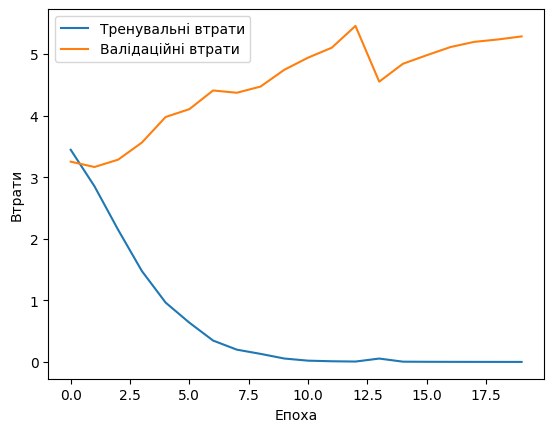

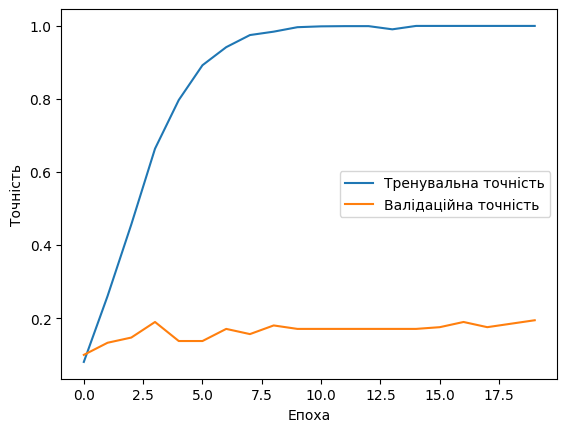

In [ ]:
plt.plot(model_result.history['loss'], label='Тренувальні втрати')
plt.plot(model_result.history['val_loss'], label='Валідаційні втрати')
plt.xlabel('Епоха')
plt.ylabel('Втрати')
plt.legend()
plt.show()

plt.plot(model_result.history['accuracy'], label='Тренувальна точність')
plt.plot(model_result.history['val_accuracy'], label='Валідаційна точність')
plt.xlabel('Епоха')
plt.ylabel('Точність')
plt.legend()
plt.show()